# Visualize Reference Gene File

In [1]:
import os
import xmltodict

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw
from random import randint, seed
from xmlparse import xmlToGeometry, loadScores

from score_strokes import alignStrokes

import numpy as np

2024-05-16T21:41:36.571823Z [INFO ] Stylus initialized - Stylus 1.5.0 [RELEASE - Aug 29 2023 15:40:46] (c) 2006-2009 Biologic Institute


In [2]:
def loadRef(han_char, ref_dir = "Reference"):
    stroke_list = []
    frac_dists = []
    ref_path = f"{ref_dir}/{han_char[0]}000/{han_char}.han"
    ref_xml = open(ref_path, "r").read()
    root = xmltodict.parse(ref_xml)
    bounds = root["hanDefinition"]["bounds"]
    x_min, y_min, x_max, y_max = (float(bounds["@left"]), float(bounds["@bottom"]), float(bounds["@right"]), float(bounds["@top"]))
    scale = (int(x_max-x_min), int(y_max-y_min))
    strokes = root["hanDefinition"]["strokes"]["stroke"]
    for stroke in strokes:
        points = stroke["points"]["forward"]
        point_arr = []
        frac_arr = []
        for point in points["pointDistance"]:
            point_arr.append((float(point["@x"])-x_min,
                              float(point["@y"])-y_min))
            frac_arr.append(float(point["@fractionalDistance"]))
        stroke_list.append(np.array(point_arr))
        frac_dists.append(np.array(frac_arr))
    return stroke_list, frac_dists, scale

def loadGeometry(data_dir, han_char, output_size = (32, 32), f_read = None):
    """
    Loads geometric data about a gene characetr directly from the XML source
    """
    if f_read is None:
        dir_list = os.listdir(f"{data_dir}/{han_char}")
        dir_list.sort()
    else:
        dir_list = f_read
    g_data = []
    f_names = []
    for f in dir_list:
        flines = open(f"{data_dir}/{han_char}/{f}", "rb").readlines()
        f_names.append(flines[0].decode()[:-1])
    for f in f_names:
        g = xmlToGeometry(f, output_size)
        g_data.append(g)
    return g_data


In [3]:
ref_g, ref_l, output_size = loadRef("5E7E", "Reference")

In [4]:
def strokeErrorMatrix(strokes, ref, p_strokes, p_ref):
    error_map = np.zeros((len(ref), len(strokes)), dtype=float)
    matches_tried = np.zeros(len(strokes), dtype=int)
    for i, ref_stroke, r_progresses in zip(range(len(ref)), ref, p_ref):
        for j, candidate_stroke, c_progresses in zip(range(len(strokes)), strokes, p_strokes):
            error_map[i, j] = strokeError(ref_stroke, candidate_stroke, r_progresses, c_progresses)
    return error_map

def strokeError(stroke, ref_stroke, p_stroke, p_ref, mode="max"):
    forward_stroke_error, back_stroke_error = np.zeros(len(ref_stroke)), np.zeros(len(ref_stroke))
    forward_ref_error, back_ref_error = np.zeros(len(stroke)), np.zeros(len(stroke))
    for i, rpoint, rprogress in zip(range(len(ref_stroke)), ref_stroke, p_ref):
        forward_stroke_error[i] = np.linalg.norm((rpoint-strokeTrace(stroke, p_stroke, rprogress)))
    for i, rpoint, rprogress in zip(range(len(ref_stroke)), ref_stroke[::-1], p_ref[::-1]):
        back_stroke_error[i] = np.linalg.norm((rpoint-strokeTrace(stroke, p_stroke, 1-rprogress)))
    for i, point, progress in zip(range(len(stroke)), stroke, p_stroke):
        forward_ref_error[i] = np.linalg.norm((point-strokeTrace(ref_stroke, p_ref, progress)))
    for i, point, progress in zip(range(len(stroke)), stroke[::-1], p_stroke[::-1]):
        back_ref_error[i] = np.linalg.norm((point-strokeTrace(ref_stroke, p_ref, 1-progress)))
    final_error = min(max(forward_stroke_error.sum(), forward_ref_error.sum()), max(back_stroke_error.sum(), back_ref_error.sum()))
    return final_error

def strokeTrace(stroke, stroke_progresses, progress):
    if progress == 1:
        return stroke[-1]
    progress_line = len(stroke_progresses)-1
    for i in range(1, len(stroke_progresses)):
        if stroke_progresses[i] > progress:
            progress_line = i-1
            break
    startp, endp = stroke_progresses[progress_line], stroke_progresses[progress_line+1]
    norm_progress = (progress-startp)/endp
    if stroke[progress_line+1][0] == stroke[progress_line][0]:
        x = stroke[progress_line][0]
        y = norm_progress*(stroke[progress_line+1][1]-stroke[progress_line][1])+stroke[progress_line][0]
    else:
        slope = (stroke[progress_line+1][1]-stroke[progress_line][1])/(stroke[progress_line+1][0]-stroke[progress_line][0])
        intercept = stroke[progress_line][1]-slope*stroke[progress_line][0]
        x = norm_progress*(stroke[progress_line+1][0]-stroke[progress_line][0])+stroke[progress_line][0]
        y = slope*x + intercept
    return np.array((x, y))


In [5]:
xcolors = ["#7e1e9c", "#15b01a", "#0343df", "#653700", "#e50000", "#f97306", "#033500", "#ffff14", "#436bad", "#840000", "#bf9005", "#5729ce"]
color_selection = [(int(c[1:3], 16), int(c[3:5], 16), int(c[5:7], 16)) for c in xcolors]

In [6]:
def visualizeRef(han_char, ref_dir="Reference", data_dir="HanBitmap"):
    ref_g, ref_l, output_size = loadRef(han_char, ref_dir)
    img = Image.new(mode="RGBA", size=output_size)
    seed(ref_l[0][0])
    colors = color_selection[:len(ref_l)+1]

    for i in range(len(ref_g)):
        draw = ImageDraw.Draw(img)
        for a in range(len(ref_g[i])-1):
            x1, y1 = ref_g[i][a]
            x2, y2 = ref_g[i][a+1]
            y1 = -(y1-output_size[1]/2)+output_size[1]/2
            y2 = -(y2-output_size[1]/2)+output_size[1]/2
            tcolor = colors[i]
            draw.line(((x1, y1), (x2, y2)), width=3, fill=tcolor)
            
    display(img)

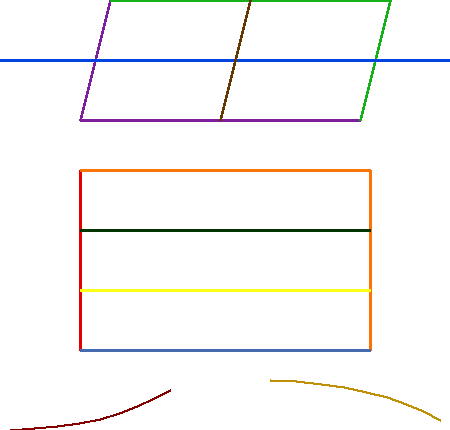

In [7]:
visualizeRef("8CAB")